In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import healpy as hp
import pickle as pkl
import os

import GCRCatalogs
from GCRCatalogs import GCRQuery
GCRCatalogs.set_root_dir("/data/scratch/dc2_nfs/")

We specify the path at which we'll save the pkl file:

In [2]:
file_name = "dc2_lensing_catalog_alt.pkl"
file_path = os.path.join("/data", "scratch", "dc2local", file_name)
file_already_populated = os.path.isfile(file_path)

---

### Truth

We load in the truth catalog and list all available quantities:

In [3]:
truth_cat = GCRCatalogs.load_catalog('desc_dc2_run2.2i_dr6_truth')

In [4]:
truth_cat.list_all_quantities()

['mag_u',
 'match_sep',
 'flux_i',
 'tract',
 'id',
 'truth_type',
 'flux_g',
 'mag_y',
 'mag_r',
 'rv',
 'host_galaxy',
 'mag_i',
 'av',
 'flux_u',
 'is_nearest_neighbor',
 'cosmodc2_id',
 'flux_z',
 'ra',
 'id_string',
 'flux_r',
 'flux_y',
 'mag_g',
 'is_unique_truth_entry',
 'mag_z',
 'cosmodc2_hp',
 'patch',
 'dec',
 'is_good_match',
 'redshift',
 'match_objectId']

And we fetch the variables we want:

In [32]:
truth_df = truth_cat.get_quantities(
    quantities = ["cosmodc2_id", "id", "match_objectId",
                  "truth_type", "ra", "dec", "redshift",
                  "flux_u", "flux_g", "flux_r", "flux_i", "flux_z", "flux_y",
                  "mag_u", "mag_g", "mag_r", "mag_i", "mag_z", "mag_y"]
)

truth_df = pd.DataFrame(truth_df)

We see that there are around 47 million objects in the truth table:

In [33]:
truth_df.shape

(47003941, 19)

A small number of these objects are stars or supernovae rather than galaxies, so we filter those out:

In [34]:
truth_df = truth_df[truth_df['truth_type'] == 1]

In [35]:
truth_df.shape

(46707830, 19)

We also only include galaxies with an r-band flux greater than or equal to 50:

In [36]:
truth_df = truth_df[truth_df['flux_r'] >= 50]

In [37]:
truth_df.shape

(12379610, 19)

We create an ra/dec filter that we'll apply to CosmoDC2, as well as an equivalent (but faster) healpix filter:

In [38]:
max_ra = np.nanmax(truth_df['ra'])
min_ra = np.nanmin(truth_df['ra'])
max_dec = np.nanmax(truth_df['dec'])
min_dec = np.nanmin(truth_df['dec'])
ra_dec_filters = [f'ra >= {min_ra}', f'ra <= {max_ra}', f'dec >= {min_dec}', f'dec <= {max_dec}']

In [39]:
vertices = hp.ang2vec(np.array([min_ra, max_ra, max_ra, min_ra]),
                      np.array([min_dec, min_dec, max_dec, max_dec]), lonlat=True)
ipix = hp.query_polygon(32, vertices, inclusive=True)
healpix_filter = GCRQuery((lambda h: np.isin(h, ipix, True), "healpix_pixel"))

Here are the ID variables in the truth table:

In [40]:
truth_df[['cosmodc2_id', 'id', 'match_objectId']]

,cosmodc2_id,id,match_objectId
0,8757401501,8757401501,15982501021353368
1,8750694182,8750694182,15982501021353393
2,8752812073,8752812073,15982501021353397
3,8750045581,8750045581,15982501021353414
4,8751841300,8751841300,15982501021353419
...,...,...,...
47003881,7875799656,7875799656,-1
47003882,7875624948,7875624948,-1
47003883,7875517662,7875517662,-1
47003889,7875348305,7875348305,-1


We see that `id` and `cosmodc2_id` are equivalent, at least for galaxies:

In [41]:
(truth_df['cosmodc2_id'] == truth_df['id']).mean()

1.0

And note that roughly a quarter of the galaxies are not matched in the object table, while the remaining three quarters are matched:

In [47]:
print((truth_df['match_objectId'] == -1).sum())
print((truth_df['match_objectId'] > -1).sum())

3034326
9345284


### Object-with-truth–match

We load in the object-with-truth-match catalog and list all available quantities:

In [48]:
object_truth_cat = GCRCatalogs.load_catalog('desc_dc2_run2.2i_dr6_object_with_truth_match')

In [49]:
object_truth_cat.list_all_quantities()

['psFluxErr_i',
 'psFlux_z',
 'x',
 'cModelFluxErr_z',
 'rv_truth',
 'snr_r_cModel',
 'cModelFluxErr_r',
 'IyyPSF_pixel_z',
 'mag_i',
 'mag_i_cModel',
 'IyyPSF_pixel_r',
 'IxyPSF_pixel_g',
 'is_nearest_neighbor',
 'snr_i_cModel',
 'Iyy_pixel_i',
 'cModelFlux_flag_y',
 'is_unique_truth_entry',
 'psFlux_u',
 'IxyPSF_pixel_u',
 'Iyy_pixel_y',
 'IxxPSF_pixel_g',
 'magerr_y_cModel',
 'id_string_truth',
 'clean',
 'psf_fwhm_z',
 'Ixx_pixel_z',
 'snr_y_cModel',
 'yErr',
 'mag_r_truth',
 'IxyPSF_pixel_z',
 'id_truth',
 'IyyPSF_pixel_g',
 'mag_g',
 'psf_fwhm_i',
 'av_truth',
 'psf_fwhm_r',
 'patch',
 'psFlux_i',
 'dec_truth',
 'host_galaxy_truth',
 'Iyy_pixel_u',
 'magerr_u_cModel',
 'magerr_z_cModel',
 'snr_z_cModel',
 'IxyPSF_pixel',
 'ra_truth',
 'IxxPSF_pixel_u',
 'flux_r_truth',
 'Ixx_pixel_g',
 'psFluxErr_z',
 'IyyPSF_pixel',
 'I_flag_u',
 'magerr_y',
 'mag_g_cModel',
 'Ixx_pixel_r',
 'Ixx_pixel_i',
 'psf_fwhm_g',
 'Iyy_pixel_r',
 'IxxPSF_pixel',
 'cModelFlux_flag_u',
 'magerr_i',
 'Ixy_p

And we fetch the variables we want:

In [107]:
object_truth_df = object_truth_cat.get_quantities(
    quantities = ["cosmodc2_id_truth", "Ixx_pixel", "Iyy_pixel", "Ixy_pixel",
                  "IxxPSF_pixel_u", "IxxPSF_pixel_g", "IxxPSF_pixel_r", "IxxPSF_pixel_i", "IxxPSF_pixel_z", "IxxPSF_pixel_y", 
                  "IyyPSF_pixel_u", "IyyPSF_pixel_g", "IyyPSF_pixel_r", "IyyPSF_pixel_i", "IyyPSF_pixel_z", "IyyPSF_pixel_y",
                  "IxyPSF_pixel_u", "IxyPSF_pixel_g", "IxyPSF_pixel_r", "IxyPSF_pixel_i", "IxyPSF_pixel_z", "IxyPSF_pixel_y",
                  "psf_fwhm_u", "psf_fwhm_g", "psf_fwhm_r", "psf_fwhm_i", "psf_fwhm_z", "psf_fwhm_y"]
)

object_truth_df = pd.DataFrame(object_truth_df)

We see that there are around 11.1 million objects in the object-truth table:

In [77]:
object_truth_df.shape

(11116206, 47)

We don't need to explicitly filter out stars, supernovae, and faint galaxies as we did above, as this will happen implicitly when we merge `object_truth_df` with `truth_df`.

---

### CosmoDC2

Next, we load in CosmoDC2 and list all available quantities:

In [83]:
config_overwrite = dict(
    catalog_root_dir='/data/scratch/dc2_nfs/cosmoDC2'
)

cosmo_cat = GCRCatalogs.load_catalog('desc_cosmodc2', config_overwrite)

In [108]:
cosmo_cat.list_all_quantities()

['sed_7843_486',
 'sed_2998_186_disk_no_host_extinction',
 'sed_3812_236_bulge_no_host_extinction',
 'mag_true_g_lsst_no_host_extinction',
 'ellipticity_1_bulge_true',
 'A_v_disk',
 'R_v_disk',
 'sed_2407_591_no_host_extinction',
 'stellar_mass_disk',
 'mag_z_sdss_no_host_extinction',
 'mag_true_y',
 'sed_4565_283_no_host_extinction',
 'mag_true_r_lsst',
 'sed_1552_381_disk',
 'sed_1552_381',
 'sed_5467_339',
 'mag_Y_lsst',
 'sed_1933_474_disk',
 'sed_6548_406_disk_no_host_extinction',
 'sed_7843_486_disk_no_host_extinction',
 'size_true',
 'sed_4565_283_bulge_no_host_extinction',
 'sed_5467_339_no_host_extinction',
 'sed_1552_381_no_host_extinction',
 'sed_15143_2259_disk_no_host_extinction',
 'sed_11467_1710',
 'sed_2407_591_disk_no_host_extinction',
 'sed_8846_549_bulge',
 'galaxy_id',
 'ellipticity_1_disk_true_dc2',
 'sed_3812_236_bulge',
 'A_v_bulge',
 'sed_5806_360',
 'ellipticity_2_disk_true',
 'sed_1933_474',
 'sed_7385_458_disk',
 'sed_6954_431_no_host_extinction',
 'sed_4299_

And we fetch the variables we want.

Some notes:
- We only pull objects in the ra/dec region from the object-with-truth-match table, using the filters defined above.
- ellipticity_1_true and ellipticity_2_true are the unlensed ellipticities. Ideally we'd want the lensed versions ellipticity_1 and ellipticity_2, which are listed [here](https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md) but are not available (see the above list). There's also ellipticity_1_true_dc2 and ellipticity_2_true_dc2, but those are deprecated.

In [109]:
cosmo_df = cosmo_cat.get_quantities(
    quantities = ["galaxy_id", "ra", "dec",
                  "ellipticity_1_true", "ellipticity_2_true",
                  "shear_1", "shear_2", "convergence"],
    filters = ra_dec_filters,
    native_filters = healpix_filter
)
cosmo_df = pd.DataFrame(cosmo_df)

We see that there are around 128 million galaxies in CosmoDC2:

In [110]:
cosmo_df.shape

(128290243, 8)

---

### Merge `truth_df` and `object_truth_df`

We merge the truth table with the object-with-truth-match table using CosmoDC2 ID:

In [140]:
merge_df1 = truth_df.merge(
    object_truth_df, 
    left_on = "cosmodc2_id",
    right_on = "cosmodc2_id_truth", 
    how = "left"
)

We remove duplicated `cosmodc2_id`s. These arise because a small number of measured objects in `object_truth_df` are matched with the same `cosmodc2_id` in the truth table. But the only columns of `object_truth_df` that we are using are the `_truth` columns, so our merged data frame has the same truth values listed multiple times (as opposed to slighly different measured values corresponding to the multiple objects that were matched to the same `cosmodc2_id`).

In [141]:
merge_df1.drop_duplicates(subset = ['cosmodc2_id'], inplace = True)

Now `merge_df1` has the same number of rows as `truth_df`, as expected:

In [142]:
merge_df1.shape

(12379610, 47)

We drop `cosmodc2_id_truth` since it's not needed anymore:

In [143]:
merge_df1.drop(columns = ["cosmodc2_id_truth"], inplace = True)

---

### Merge `merge_df1` and `cosmo_df`

And now we merge the above data frame with CosmoDC2, again using CosmoDC2 ID (which is called `galaxy_id` in `cosmo_df`):

In [144]:
merge_df2 = merge_df1.merge(
    cosmo_df,
    left_on = "cosmodc2_id",
    right_on = "galaxy_id",
    how = "left"
)

As expected, the new data frame has the same number of rows as `merge_df1`:

In [145]:
merge_df2.shape

(12379610, 54)

But we find that there are around 800,000 galaxies in the truth table that are not in `cosmo_df`:

In [146]:
print(merge_df2['galaxy_id'].isna().sum())
print(merge_df2['galaxy_id'].isna().mean())

809781
0.0654124806839634


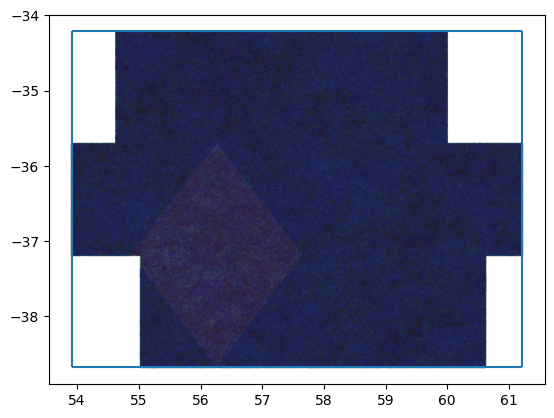

In [121]:
_ = plt.scatter(merge_df2['ra_x'][~merge_df2['galaxy_id'].isna()],
                merge_df2['dec_x'][~merge_df2['galaxy_id'].isna()],
                c = merge_df2['redshift'][~merge_df2['galaxy_id'].isna()], alpha = 0.005, s = 1)
_ = plt.vlines(x = [min_ra, max_ra], ymin = max_dec, ymax = min_dec)
_ = plt.hlines(y = [min_dec, max_dec], xmin = min_ra, xmax = max_ra)

It appears that this small number of galaxies is missing from a portion of the sky in CosmoDC2. We've confirmed that this is an inherent problem in CosmoDC2 itself and is not related to our merging strategy. The other BLISS projects that work with DC2 have encountered the same problem.

We filter these galaxies out since they do not have shear, convergence, or ellipticity (and thus are not useful for our purposes):

In [147]:
merge_df2 = merge_df2[~merge_df2['galaxy_id'].isna()]

We confirm that the distribution of per-band magnitude and the distribution of redshift are essentially the same as before:

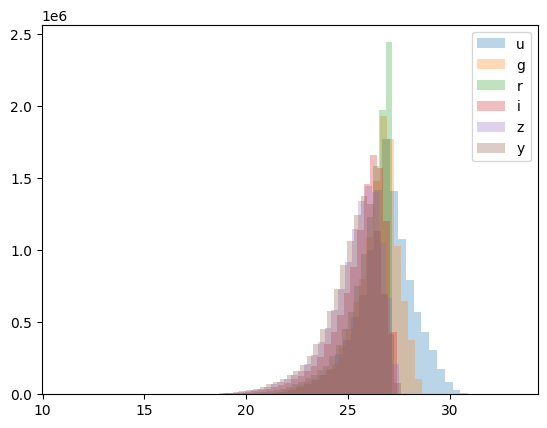

In [148]:
_ = plt.hist(merge_df2['mag_u'], bins = 50, alpha = 0.3, label = 'u')
_ = plt.hist(merge_df2['mag_g'], bins = 50, alpha = 0.3, label = 'g')
_ = plt.hist(merge_df2['mag_r'], bins = 50, alpha = 0.3, label = 'r')
_ = plt.hist(merge_df2['mag_i'], bins = 50, alpha = 0.3, label = 'i')
_ = plt.hist(merge_df2['mag_z'], bins = 50, alpha = 0.3, label = 'z')
_ = plt.hist(merge_df2['mag_y'], bins = 50, alpha = 0.3, label = 'y')
_ = plt.legend()

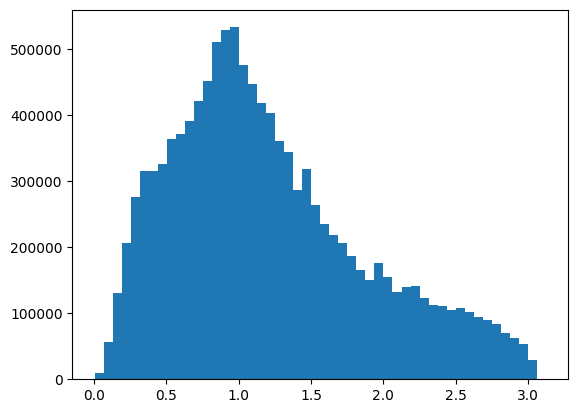

In [149]:
_ = plt.hist(merge_df2['redshift'], bins = 50)

And now we can examine shear and convergence, which were initially in `cosmo_df`:

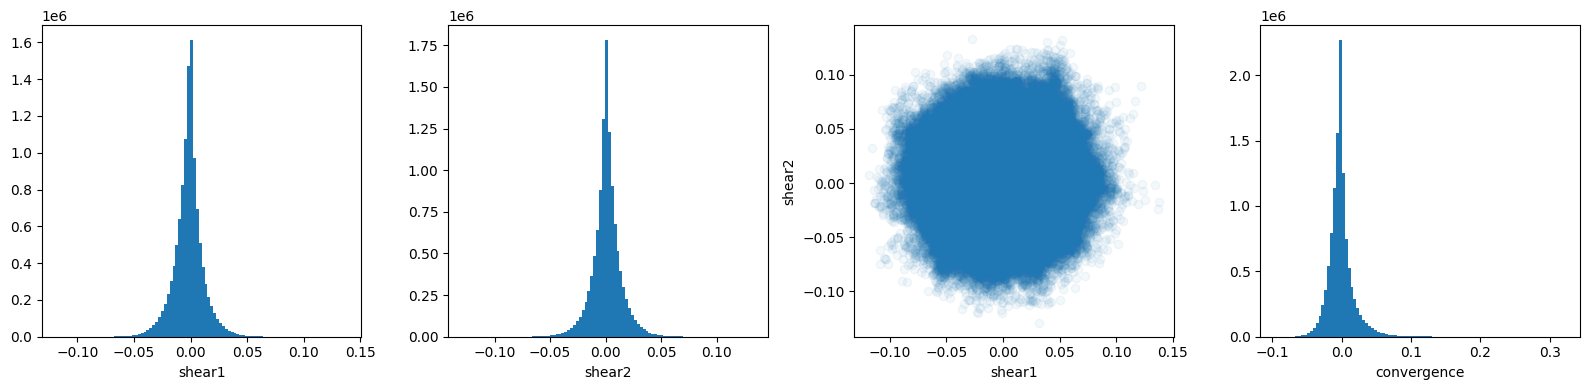

In [126]:
fig, ax = plt.subplots(1, 4, figsize = (16,4))
_ = ax[0].hist(merge_df2['shear_1'], bins = 100)
_ = ax[0].set_xlabel('shear1')
_ = ax[1].hist(merge_df2['shear_2'], bins = 100)
_ = ax[1].set_xlabel('shear2')
_ = ax[2].scatter(merge_df2['shear_1'], merge_df2['shear_2'], alpha = 0.05)
_ = ax[2].set_xlabel('shear1')
_ = ax[2].set_ylabel('shear2')
_ = ax[3].hist(merge_df2['convergence'], bins = 100)
_ = ax[3].set_xlabel('convergence')
fig.tight_layout()

In [150]:
merge_df2.shape

(11569829, 54)

We remove `ra_y` and `dec_y` since they're the same as `ra_x` and `dec_x`, respectively:

In [151]:
merge_df2.drop(columns = ['ra_y', 'dec_y'], inplace = True)

And then we rename `ra_x` and `dec_x` to `ra` and `dec`, respectively:

In [152]:
merge_df2.rename(columns = {
    "ra_x": "ra",
    "dec_x": "dec"
}, inplace = True)

In [153]:
merge_df2.isna().sum()

truth_type                  0
flux_g                      0
mag_r                       0
mag_i                       0
flux_u                      0
dec                         0
redshift                    0
mag_u                       0
flux_i                      0
id                          0
mag_y                       0
cosmodc2_id                 0
flux_z                      0
ra                          0
flux_y                      0
mag_g                       0
mag_z                       0
flux_r                      0
match_objectId              0
Ixx_pixel             3221919
IxxPSF_pixel_u        2842537
IyyPSF_pixel_z        2842519
IyyPSF_pixel_r        2842485
IxyPSF_pixel_g        2842493
IxxPSF_pixel_z        2842519
IxyPSF_pixel_u        2842537
psf_fwhm_g            2842493
IxxPSF_pixel_g        2842493
Iyy_pixel             3221919
psf_fwhm_z            2842519
IxyPSF_pixel_z        2842519
psf_fwhm_u            2842537
IyyPSF_pixel_y        2842555
IyyPSF_pix

---

Finally, we save `merge_df2` to `file_path`:

In [155]:
with open(file_path, "wb") as f:
    pkl.dump(merge_df2, f)